In [3]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import math
from src.utils import reload_script
import warnings

from models_src.Support import LRCallback
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D, LossBasedMetric
import models_src.VecModels as vcm

from models_src.VecDataset import MultishapeMapGenerator, DatasetGenerator, blur_img, op_sample_points_vecs
from models_src.fft_lib import xy_coords, decode1Dcoords, encode1Dcoords
from models_src.Trainer import TrainingProcessor2
from Fourier.datasets.generator_cfg import generator_cfg
%matplotlib inline

from models_src.Attn_variations import SqueezeImg, UnSqueezeImg

from models_src.DETR import FFN, MHA

from models_src.Mask_RCNN import CombinedMetricsModel

print(tf.config.list_physical_devices('GPU'))

[]


In [14]:
reload_script('models_src.VecModels')

In [2]:
import mlflow

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/fzzyfoxx@gmail.com/vec_detection")
mlflow.tensorflow.autolog(log_datasets=False, log_models=True, disable=True )

In [4]:
class cfg:
    train_batch_size = 32
    val_batch_size = 64
    test_batch_size = 8
    sample_points = 20
    ds_path = './datasets/pixel_similarity'

msmg = MultishapeMapGenerator(['img', 'angle_label', 'center_vec_label', 'line_label', 'shape_label', 'thickness_label', 'pattern_masks', 'shape_masks', 'vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask', 'shape_thickness'],
                              generator_cfg.size, 
                              **generator_cfg.drawing_args, 
                              patterns_prob=generator_cfg.patterns_prob, 
                              line_args=generator_cfg.line_args, 
                              shape_args=generator_cfg.shape_args, 
                              line_filled_args=generator_cfg.line_filled_args, 
                              polyline_args=generator_cfg.polyline_args, 
                              linear_shapes_args=generator_cfg.linear_shapes_args, 
                              spreaded_shapes_args=generator_cfg.spreaded_shapes_args
                              )

dg = DatasetGenerator(msmg, 
                      ds_path='./datasets/pixel_similarity', 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=True, 
                      output_filter=['img','vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask'],
                      preprocess_funcs=[(blur_img, {'blur_ratio_range': (0.1, 0.6), 'kernel_size': 3, 'color_rand_range': 0.1}, True),
                                        (op_sample_points_vecs, {'n': cfg.sample_points}, True)]
                      )

ds, train_steps = dg.dataset(from_saved=True, batch_size=cfg.train_batch_size, validation=False, val_idxs=[0], shuffle_buffer_size=128)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=cfg.val_batch_size, validation=True, val_idxs=[0])
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=cfg.test_batch_size, validation=True, val_idxs=[0])

ds_iter = iter(ds)
val_iter = iter(val_ds)
test_iter = iter(test_ds)

In [6]:
def radial_enc_vec_detection_model_generator(
        enc_type,
        num_heads,
        embs_dim,
        color_embs_dim,
        size,
        embs_mid_layers,
        dropout,
        activation,
        out_mid_layers,
        attns_num,
        pos_enc_matmul,
        queries_self_attn,
        queries_pos_enc_values,
        source_query_cross_attn,
        sample_queries_num,
        backbone_args,
        backbone_weights_path,
        backbone_generator,
        backbone_last_layer,
        backbone_init_layer,
        backbone_trainable,
        name='RadVecDet'
):
    
    backbone_model = backbone_generator(**backbone_args)
    if backbone_weights_path is not None:
        backbone_model.load_weights(f'./{backbone_weights_path}.weights.h5')

    backbone_model.trainable = backbone_trainable

    img_inputs = backbone_model.input
    memory = backbone_model.get_layer(backbone_last_layer).output
    normed_img = backbone_model.get_layer(backbone_init_layer).output

    sample_inputs = tf.keras.layers.Input((cfg.sample_points,2), name='sample_points')
    split_inputs = tf.keras.layers.Input((cfg.sample_points,), name='class_split')

    enc_func = vcm.FrequencyRadialEncoding if enc_type!='separate' else vcm.SeparateRadialEncoding
    self_enc_func = vcm.SampleFrequencyRadialEncoding if enc_type!='separate' else vcm.SampleSeparateRadialEncoding
    enc_label = 'Freq' if enc_type!='separate' else 'Sep'

    pos_enc = enc_func(emb_dim=embs_dim//num_heads, height=size, name=f'{enc_label}RadialEncoding')(sample_inputs)
    if queries_self_attn:
        self_pos_enc = self_enc_func(emb_dim=embs_dim//num_heads, height=size, name=f'Self{enc_label}RadialEncoding')(sample_inputs, sample_inputs)

    features, sample_features, pos_enc = vcm.SampleRadialSearchFeaturesExtraction(embs_dim=embs_dim, 
                                                                            color_embs_dim=color_embs_dim, 
                                                                            mid_layers=embs_mid_layers,
                                                                            activation=activation,
                                                                            dropout=dropout,
                                                                            batch_dims=1,
                                                                            name='SRSFE')(sample_inputs, memory, normed_img, pos_enc)

    print(pos_enc.shape, features.shape, sample_features.shape)

    value_pos_enc = not pos_enc_matmul

    for i in range(attns_num):


        x, _ = vcm.DetectionMHA(key_pos_enc=(i!=0), pos_enc_matmul=pos_enc_matmul, value_pos_enc=value_pos_enc, output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name=f'MHA_{i+1}')(features, sample_features, features, pos_enc)
        #print(x.shape)
        sample_features = vcm.AddNorm(norm_axis=-1, name=f'PostMHA-AddNorm_{i+1}')([sample_features, x])

        if queries_self_attn:
            ### sample self-attn
            V = self_pos_enc if queries_pos_enc_values else tf.keras.layers.Permute([2,1,3], name=f'PreSelfMHA-Permute_{i+1}')(x)     
            x, _ = vcm.DetectionMHA(key_pos_enc=True, value_pos_enc=False, output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name=f'SelfMHA_{i+1}')(V, sample_features, V, self_pos_enc)
            sample_features = vcm.AddNorm(norm_axis=-1, name=f'PostSelfMHA-AddNorm_{i+1}')([sample_features, x])

        if source_query_cross_attn & (i<attns_num-1):
            Q_pos_enc = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-PosEnc-Permute_{i+1}')(pos_enc)
            V = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-Sample-Permute_{i+1}')(sample_features)
            Q = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-Features-Permute_{i+1}')(features)
            x, _ = vcm.ExpandedQueriesMHA(output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name=f'CrossMHA_{i+1}')(V, Q, V, Q_pos_enc)
            x = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-Features-UnPermute_{i+1}')(x)
            features = vcm.AddNorm(norm_axis=-1, name=f'PostCrossMHA-AddNorm_{i+1}')([features, x])

        if sample_queries_num is not None:
            query_points = vcm.QuerySamplingLayer(queries_num=sample_queries_num, mid_layers=2, mid_units=embs_dim, activation='relu', dropout=0.0, name=f'Query-Sample_{i+1}')([sample_features, sample_inputs])
            query_pos_enc = self_enc_func(emb_dim=embs_dim//num_heads, height=size, expand_b=False, name=f'Query{enc_label}RadialEncoding_{i+1}')(sample_inputs, query_points)
            query_samples = vcm.SampleQueryExtractionLayer(cut_off=1, gamma=2, name=f'Query-Features_{i+1}')([features, query_points])
            sample_features = vcm.SampleQueryMessagePassing(mid_layers=3, mid_units=embs_dim*2, activation='relu', dropout=0.0, name=f'Query-Message_{i+1}')(sample_features, query_samples, query_pos_enc)


        x = FFN(mid_layers=out_mid_layers, mid_units=embs_dim*2, output_units=embs_dim, dropout=dropout, activation=activation, name=f'Decoder-FFN_{i+1}')(sample_features)
        sample_features = vcm.AddNorm(norm_axis=-1, name=f'PostFFN-AddNorm_{i+1}')([sample_features, x])
        
    vecs, class_preds = vcm.SampleRadialSearchHead(num_samples=cfg.sample_points, ffn_mid_layers=out_mid_layers, mid_units=embs_dim*2, activation=activation, dropout=0.0, name='SRShead')(sample_features, sample_inputs, split_inputs)
    vecs = tf.keras.layers.Identity(name='vecs')(vecs)
    class_preds = tf.keras.layers.Identity(name='class')(class_preds)

    model = tf.keras.Model(inputs={'img': img_inputs, 'sample_points': sample_inputs, 'class_split': split_inputs}, 
                           outputs={'vecs': vecs, 'class': class_preds}, 
                           name=name)
    
    return model

# Training

In [7]:
backbone_args = {
    'input_shape': (32,32,3),
    'init_filters_power': 6,
    'levels': 3,
    'level_convs': 4,
    'init_dropout': 0.0,
    'dropout': 0.3,
    'batch_normalization': True,
    'name': 'PxFeaturesUnet'
}

model_args = {
    'enc_type': 'frequency',
    'num_heads': 1,
    'embs_dim': 64,
    'color_embs_dim': 16,
    'size': 32,
    'embs_mid_layers': 2,
    'dropout': 0.0,
    'activation': 'relu',
    'out_mid_layers': 2,
    'attns_num': 3,
    'pos_enc_matmul': False,
    'queries_self_attn': False,
    'queries_pos_enc_values': False,
    'source_query_cross_attn': False,
    'sample_queries_num': None,
    'backbone_args': backbone_args,
    'backbone_generator': vcm.pixel_features_unet,
    'backbone_weights_path': './final_state/PxFeaturesUnet/e45_ps',
    'backbone_trainable': False,
    'backbone_last_layer': 'Up-Conv_2',
    'backbone_init_layer': 'Batch-Normalization',
}

compile_args = {
    'optimizer': tf.keras.optimizers.Adam(1e-3),
    'loss': {
        'vecs': vcm.MixedBBoxVecLoss(name='VecLoss', gamma=1, reduction='sum_over_batch_size'),
        'class': tf.keras.losses.BinaryCrossentropy(name='ClassLoss', reduction='none', axis=None)
    },
    'loss_weights': {
        'vecs': 0.7,
        'class': 0.3
    }
}

model_generator = radial_enc_vec_detection_model_generator

In [8]:
trainer = TrainingProcessor2(cfg, mlflow_instance=mlflow)
trainer.load_dataset(ds, train_steps, val_ds, val_steps)
trainer.load_model_generator(model_generator)
trainer.compile_model(
    model_args = model_args,
    print_summary = True,
    summary_kwargs = {'expand_nested': False, 'line_length': 100},
    **compile_args
)

(None, 20, 1024, 64) (None, 1, 1024, 64) (None, 20, 1, 64)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'img' mapping to value <KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=unet_input> which has name 'unet_input'. Change the tensor name to 'img' (via `Input(..., name='img')`)
  warnings.warn(


Model: "RadVecDet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ unet_input (InputLayer)     │ (None, 32, 32, 3)       │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Batch-Normalization         │ (None, 32, 32, 3)       │             12 │ unet_input[0][0]        │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Down-Conv_1 (UNetConvBlock) │ [(None, 16, 16, 64),    │        112,576 │ Batch-Normalization[0]… │
│                             │ (None, 32, 32, 64)]     │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Down-Conv_2 (UNetConvBlock) │ [(None, 8, 8, 128),     │        516,608 │ Down-Conv_1[0][0]       │
│                             │ (None, 16, 16, 128)]    │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Down-Conv_3 (UNetConvBlock) │ [(None, 4, 4, 256),     │      2,065,408 │ Down-Conv_2[0][0]       │
│                             │ (None, 8, 8, 256)]      │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ sample_points (InputLayer)  │ (None, 20, 2)           │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Up-Conv_1 (UNetUpConvBlock) │ (None, 16, 16, 128)     │        868,992 │ Down-Conv_3[0][1],      │
│                             │                         │                │ Down-Conv_2[0][1]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Up-Conv_2 (UNetUpConvBlock) │ (None, 32, 32, 64)      │        217,408 │ Up-Conv_1[0][0],        │
│                             │                         │                │ Down-Conv_1[0][1]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ FreqRadialEncoding          │ (None, 20, 32, 32, 64)  │              0 │ sample_points[0][0]     │
│ (FrequencyRadialEncoding)   │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ SRSFE                       │ [(None, 1, 1024, 64),   │         34,400 │ sample_points[0][0],    │
│ (SampleRadialSearchFeature… │ (None, 20, 1, 64),      │                │ Up-Conv_2[0][0],        │
│                             │ (None, 20, 1024, 64)]   │                │ Batch-Normalization[0]… │
│                             │                         │                │ FreqRadialEncoding[0][… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ MHA_1 (DetectionMHA)        │ [(None, 20, 1, 64),     │         16,640 │ SRSFE[0][0],            │
│                             │ (None, 20, 1, 1, 1024)] │                │ SRSFE[0][1],            │
│                             │                         │                │ SRSFE[0][0],            │
│                             │                         │                │ SRSFE[0][2]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ PostMHA-AddNorm_1 (AddNorm) │ (None, 20, 1, 64)       │            128 │ SRSFE[0][1],            │
│                             │                         │    

 Total params: 3,990,833 (15.22 MB)

 Trainable params: 209,829 (819.64 KB)

 Non-trainable params: 3,781,004 (14.42 MB)

None


In [8]:
trainer.train_model(
    epochs = 20,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.95)],
    log = False,
    export_final_state = False,
    export_model = False
)

2024-08-14 10:30:37.179704: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1723624237.257234   28109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.7787

2024-08-14 10:30:50.016659: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 8 bytes spill stores, 8 bytes spill loads

2024-08-14 10:30:51.373115: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 260 bytes spill stores, 260 bytes spill loads



512/512 ━━━━━━━━━━━━━━━━━━━━ 59s 45ms/step - loss: 3.7775 - val_loss: 2.7842 - learning_rate: 0.0010
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.6639 - val_loss: 2.5680 - learning_rate: 9.5000e-04
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.5256 - val_loss: 2.4726 - learning_rate: 9.0250e-04
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.4186 - val_loss: 2.3997 - learning_rate: 8.5737e-04
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.3565 - val_loss: 2.3729 - learning_rate: 8.1451e-04
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.3045 - val_loss: 2.2857 - learning_rate: 7.7378e-04
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.2585 - val_loss: 2.2220 - learning_rate: 7.3509e-04
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.2206 - val_loss: 2.2016 - learning_rate: 6.9834e-04
Epoch 9/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.1856 - val_loss: 2.2167

In [25]:
tf.config.experimental.get_memory_info('GPU:0')['peak']*1e-6

805.860864

In [50]:
trainer.save_temp_weights('./final_state', filename='e40_base', use_model_name=True)

In [9]:
trainer.load_temp_weights('final_state/RadVecDet/e40_base', skip_mismatch=False)

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 158 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
mlflow.end_run(status="KILLED")

## Metric Validation

In [26]:
vec_mixed_metric = LossBasedMetric(vcm.MixedBBoxVecLoss(name='VecMixLoss', gamma=1, reduction='none'))
vec_metric = LossBasedMetric(vcm.VecLoss(name='VecLoss', gamma=1, reduction='none'))
bbox_metric = LossBasedMetric(vcm.BBoxVecLoss(name='BBoxLoss', gamma=1, reduction='none'))
class_metric = LossBasedMetric(tf.keras.losses.BinaryCrossentropy(name='ClassLoss', reduction='none', axis=None))

@tf.function(input_signature=[tf.TensorSpec(shape=(cfg.test_batch_size,32,32,3), dtype=tf.float32), 
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points,2), dtype=tf.int32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points,4,2), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(), dtype=tf.int32),
                              ], 
                              jit_compile=True, autograph=False)
def tf_eval(img, sample_points, class_split, vecs_label, class_label, class_weights, n):
    vecs_pred, class_pred = trainer.model({'img': img, 'sample_points': sample_points, 'class_split': class_split}, training=False).values()
    vec_mixed_metric.update_state(vecs_label, vecs_pred, class_weights)
    class_metric.update_state(class_label, class_pred, class_weights)

    components_mask = tf.where(class_weights>0, 1.0, 0.0)
    B = tf.shape(img)[0]
    vecs_mask = class_split*components_mask
    vecs_num = tf.reduce_sum(vecs_mask, axis=None, keepdims=True)
    vecs_weights = vecs_mask*tf.math.divide_no_nan(tf.cast(n*B, tf.float32), vecs_num)

    bbox_mask = (1-class_split)*components_mask
    bbox_num = tf.reduce_sum(bbox_mask, axis=None, keepdims=True)
    bbox_weights = bbox_mask*tf.math.divide_no_nan(tf.cast(n*B, tf.float32), bbox_num)

    vecs_pred, bbox_pred = tf.split(vecs_pred, 2, axis=-2)
    vecs_label, bbox_label = tf.split(vecs_label, 2, axis=-2)

    vec_metric.update_state(vecs_label, vecs_pred, vecs_weights)
    bbox_metric.update_state(bbox_label, bbox_pred, bbox_weights)

In [27]:
with tf.device('/GPU:0'):
    vec_mixed_metric.reset_state()
    class_metric.reset_state()
    pb = tf.keras.utils.Progbar(test_steps, stateful_metrics=['VecMixLoss','VecLoss', 'BBoxLoss', 'ClassLoss'])

    for i in range(test_steps):
        features, labels, labels_weights = next(test_iter)
        img, sample_points, class_split = features.values()
        vecs_labels, components_class = labels.values()
        vecs_weights, class_weights = labels_weights.values()
        tf_eval(img, sample_points, class_split, vecs_labels, components_class, class_weights, cfg.sample_points)
        pb.update(i+1, values=[('VecMixLoss', vec_mixed_metric.result().numpy()),
                               ('VecLoss', vec_metric.result().numpy()),
                               ('BBoxLoss', bbox_metric.result().numpy()),
                               ('ClassLoss', class_metric.result().numpy())])

2024-08-14 10:20:14.023832: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 8 bytes spill stores, 8 bytes spill loads

2024-08-14 10:20:14.730898: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 16 bytes spill stores, 16 bytes spill loads



256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - VecMixLoss: 2.3952 - VecLoss: 3.1100 - BBoxLoss: 1.1090 - ClassLoss: 0.5082


In [28]:
run_id = mlflow.search_runs(order_by=['start_time DESC']).iloc[0].run_id
with mlflow.start_run(run_id=run_id):
    for metric_name, metric_value in zip(['VecMixedLoss', 'VecLoss', 'BBoxLoss', 'ClassLoss'], [m.result().numpy() for m in [vec_mixed_metric, vec_metric, bbox_metric, class_metric]]):
        mlflow.log_metric(metric_name, metric_value)

# Test

img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>


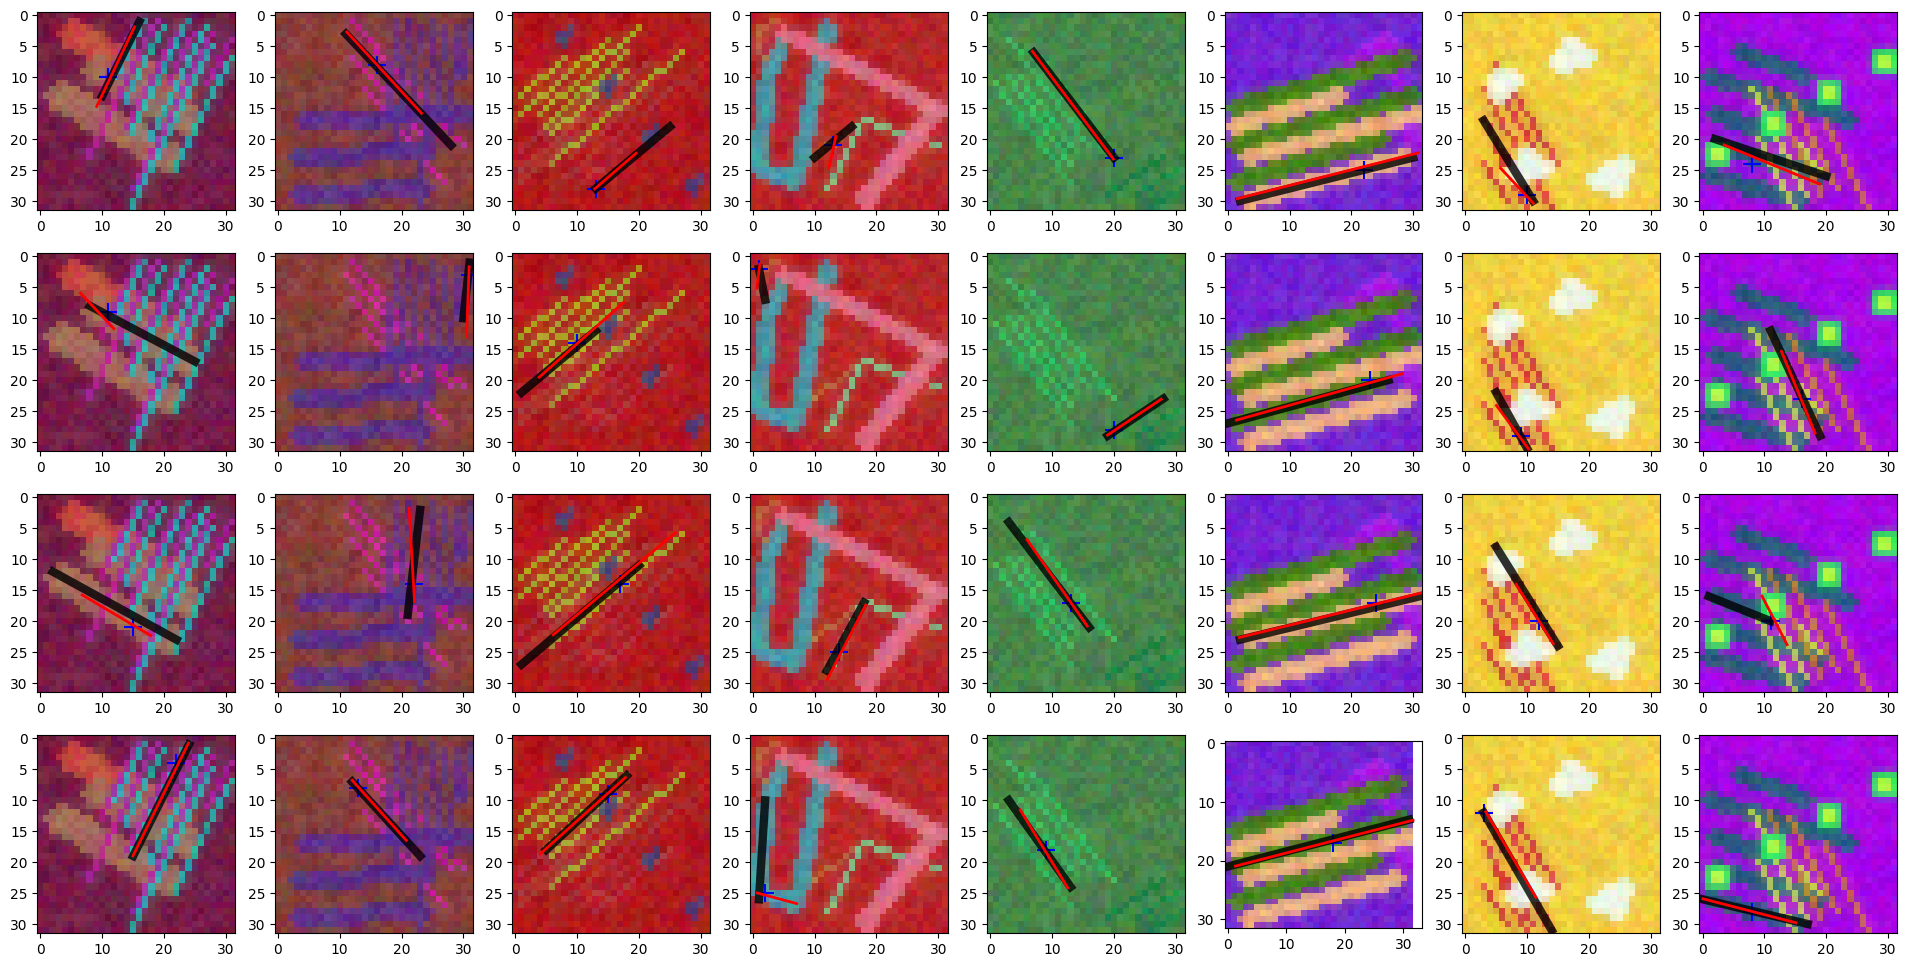

In [40]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)

pred_vecs, pred_class = trainer.model(features, training=False).values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)

pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=4
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]
    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r,i]
        ax.imshow(img[i])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='blue', s=150)
        ax.plot(*i_components[r], color='black', linewidth=6, alpha=0.8)
        ax.plot(*p_components[r], color='red', linewidth=2)

# Mid Layers Analysis

## MHA scores map

In [10]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('MHA_2').output[1], trainer.model.output))

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'img' mapping to value <KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=unet_input> which has name 'unet_input'. Change the tensor name to 'img' (via `Input(..., name='img')`)
  warnings.warn(


img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>


2024-08-14 15:37:49.815369: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>
scores_map (8, 20, 32, 32) <dtype: 'float32'>


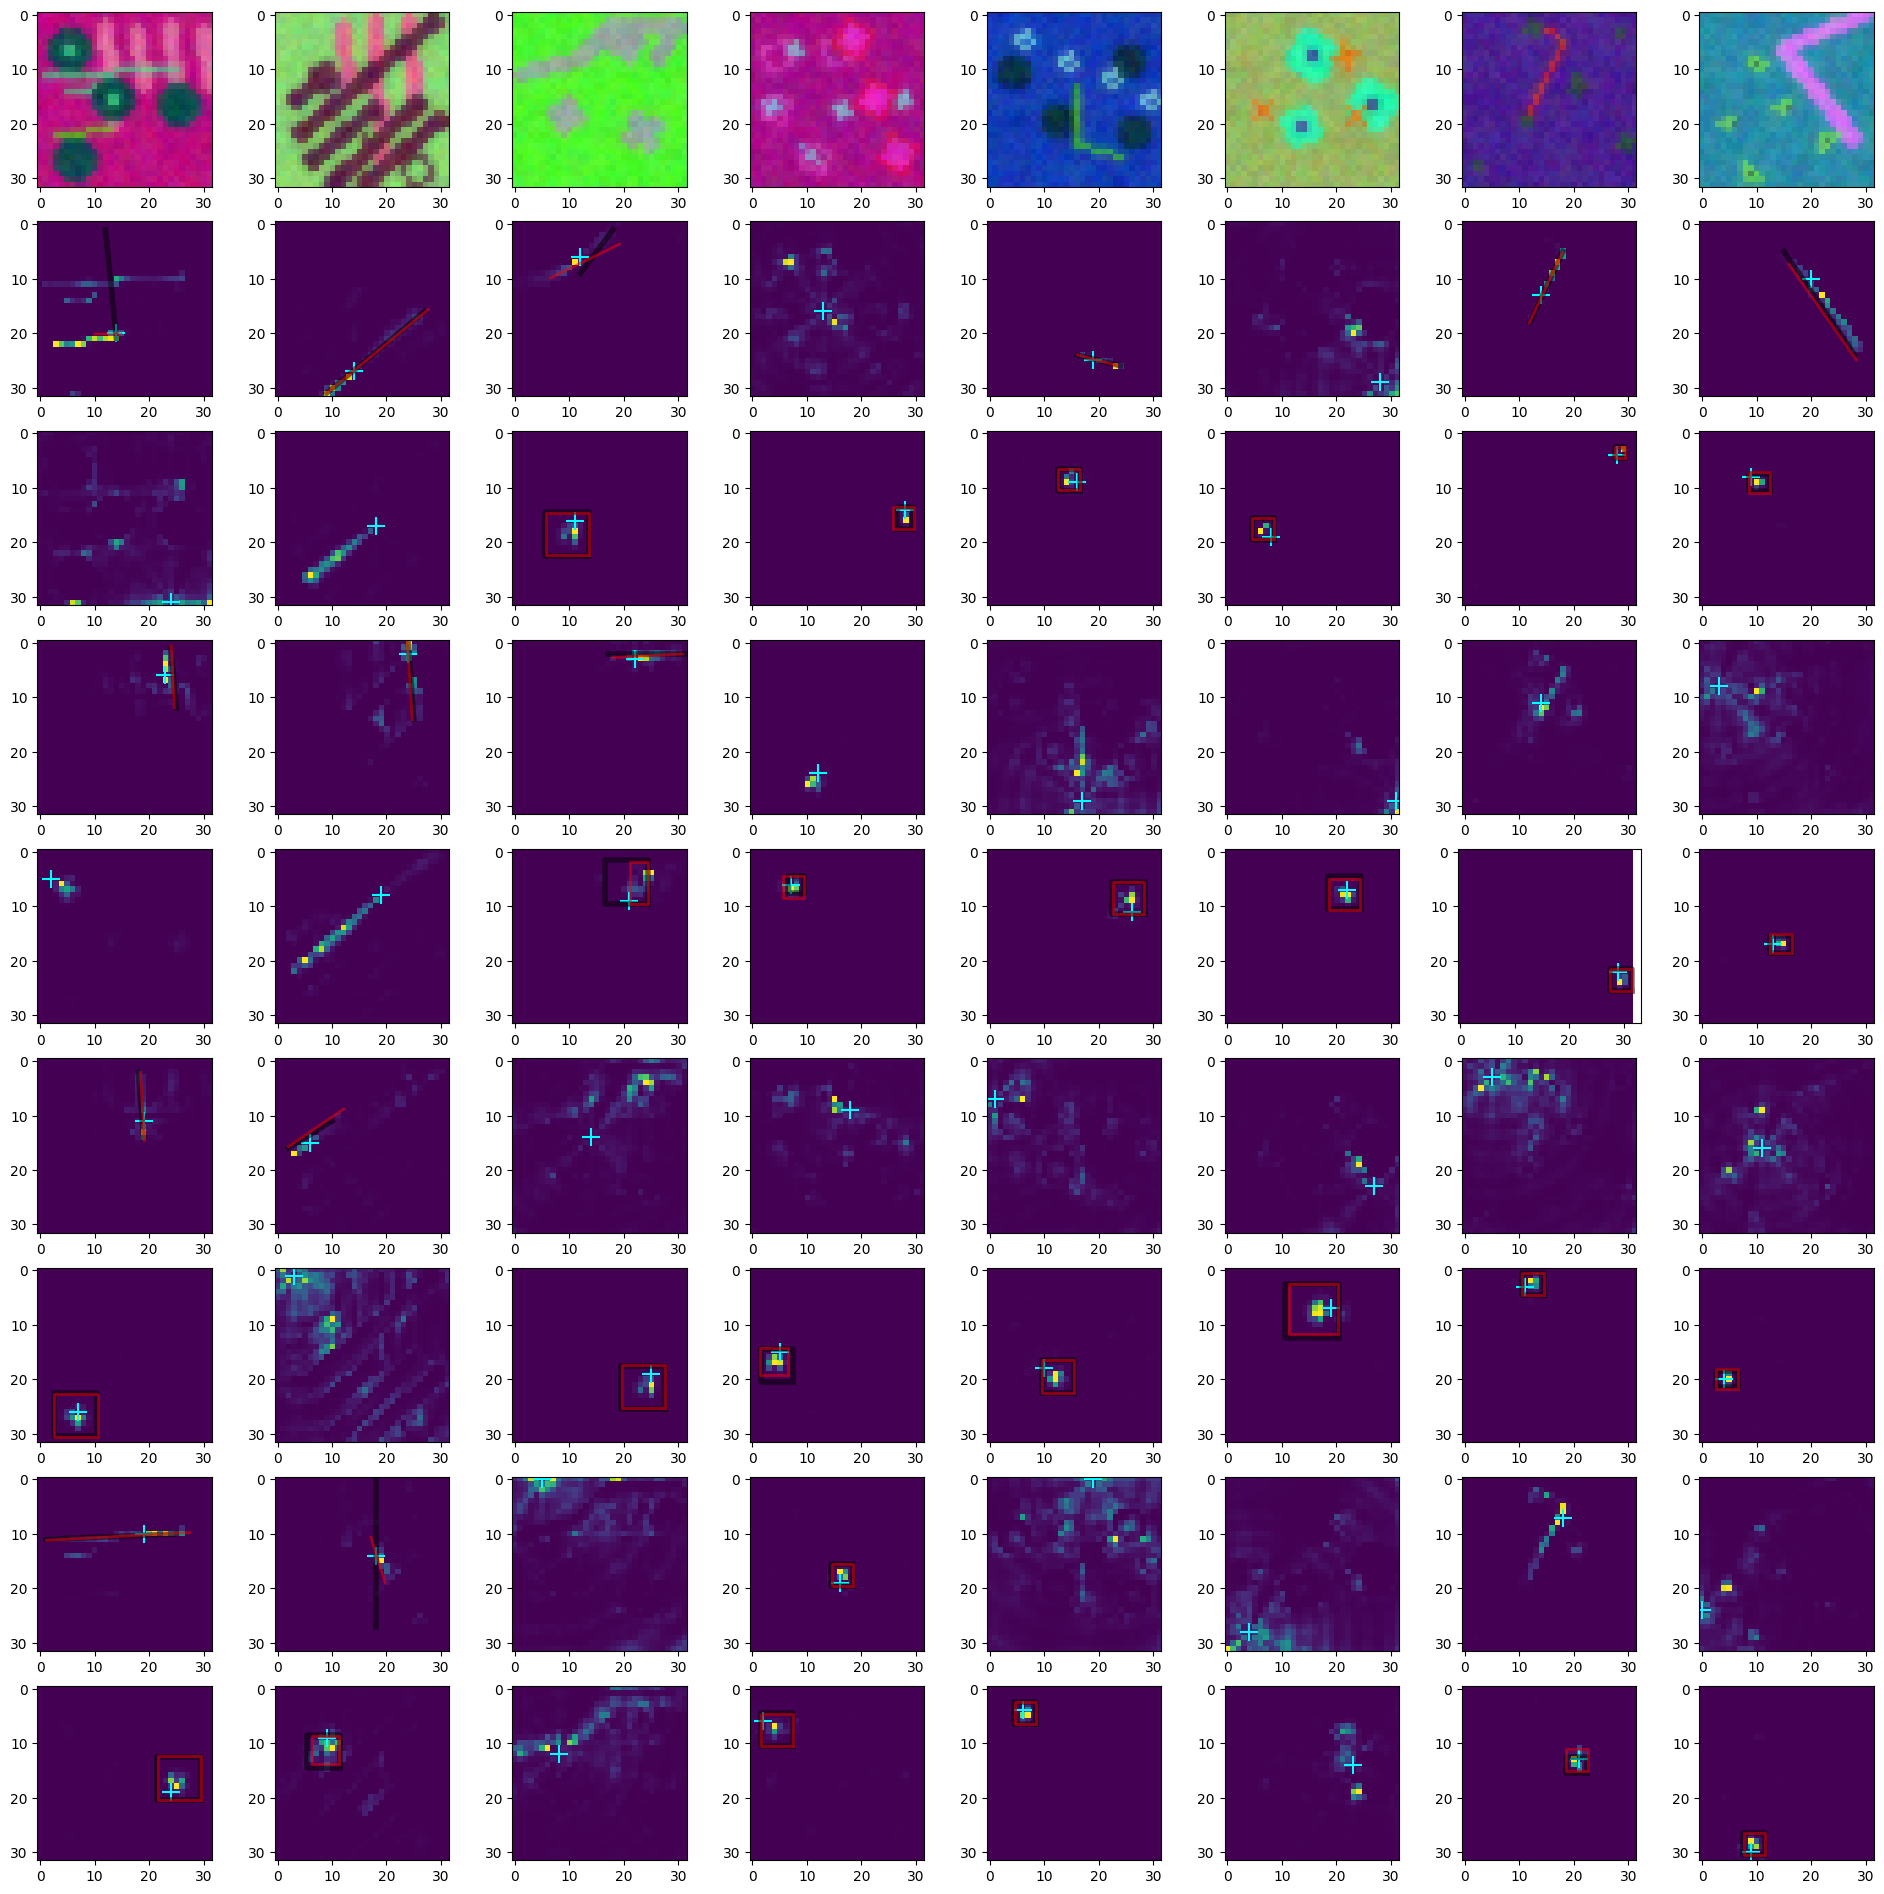

In [11]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)



scores_map, preds  = inter_model(features, training=False)
scores_map = tf.reshape(scores_map, (cfg.test_batch_size, cfg.sample_points, generator_cfg.size, generator_cfg.size))
pred_vecs, pred_class = preds.values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)
print('scores_map', scores_map.shape, scores_map.dtype)
pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=8
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows+1, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]

    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_maps = tf.concat([tf.gather(scores_map[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(scores_map[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_weights = tf.concat([tf.gather(class_weights[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(class_weights[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    axs[0,i].imshow(img[i])
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r+1,i]
        r = r if r%2==0 else r//2+cfg.sample_points//2
        ax.imshow(i_maps[r])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='aqua', s=150)
        if i_weights[r]>0:
            ax.plot(*i_components[r], color='black', linewidth=4, alpha=0.5)
            ax.plot(*p_components[r], color='red', linewidth=2, alpha=0.5)

## Query-Samples

In [36]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('Query-Sample_2').output, trainer.model.output))

img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>
queries_points (8, 20, 8, 2) <dtype: 'float32'>


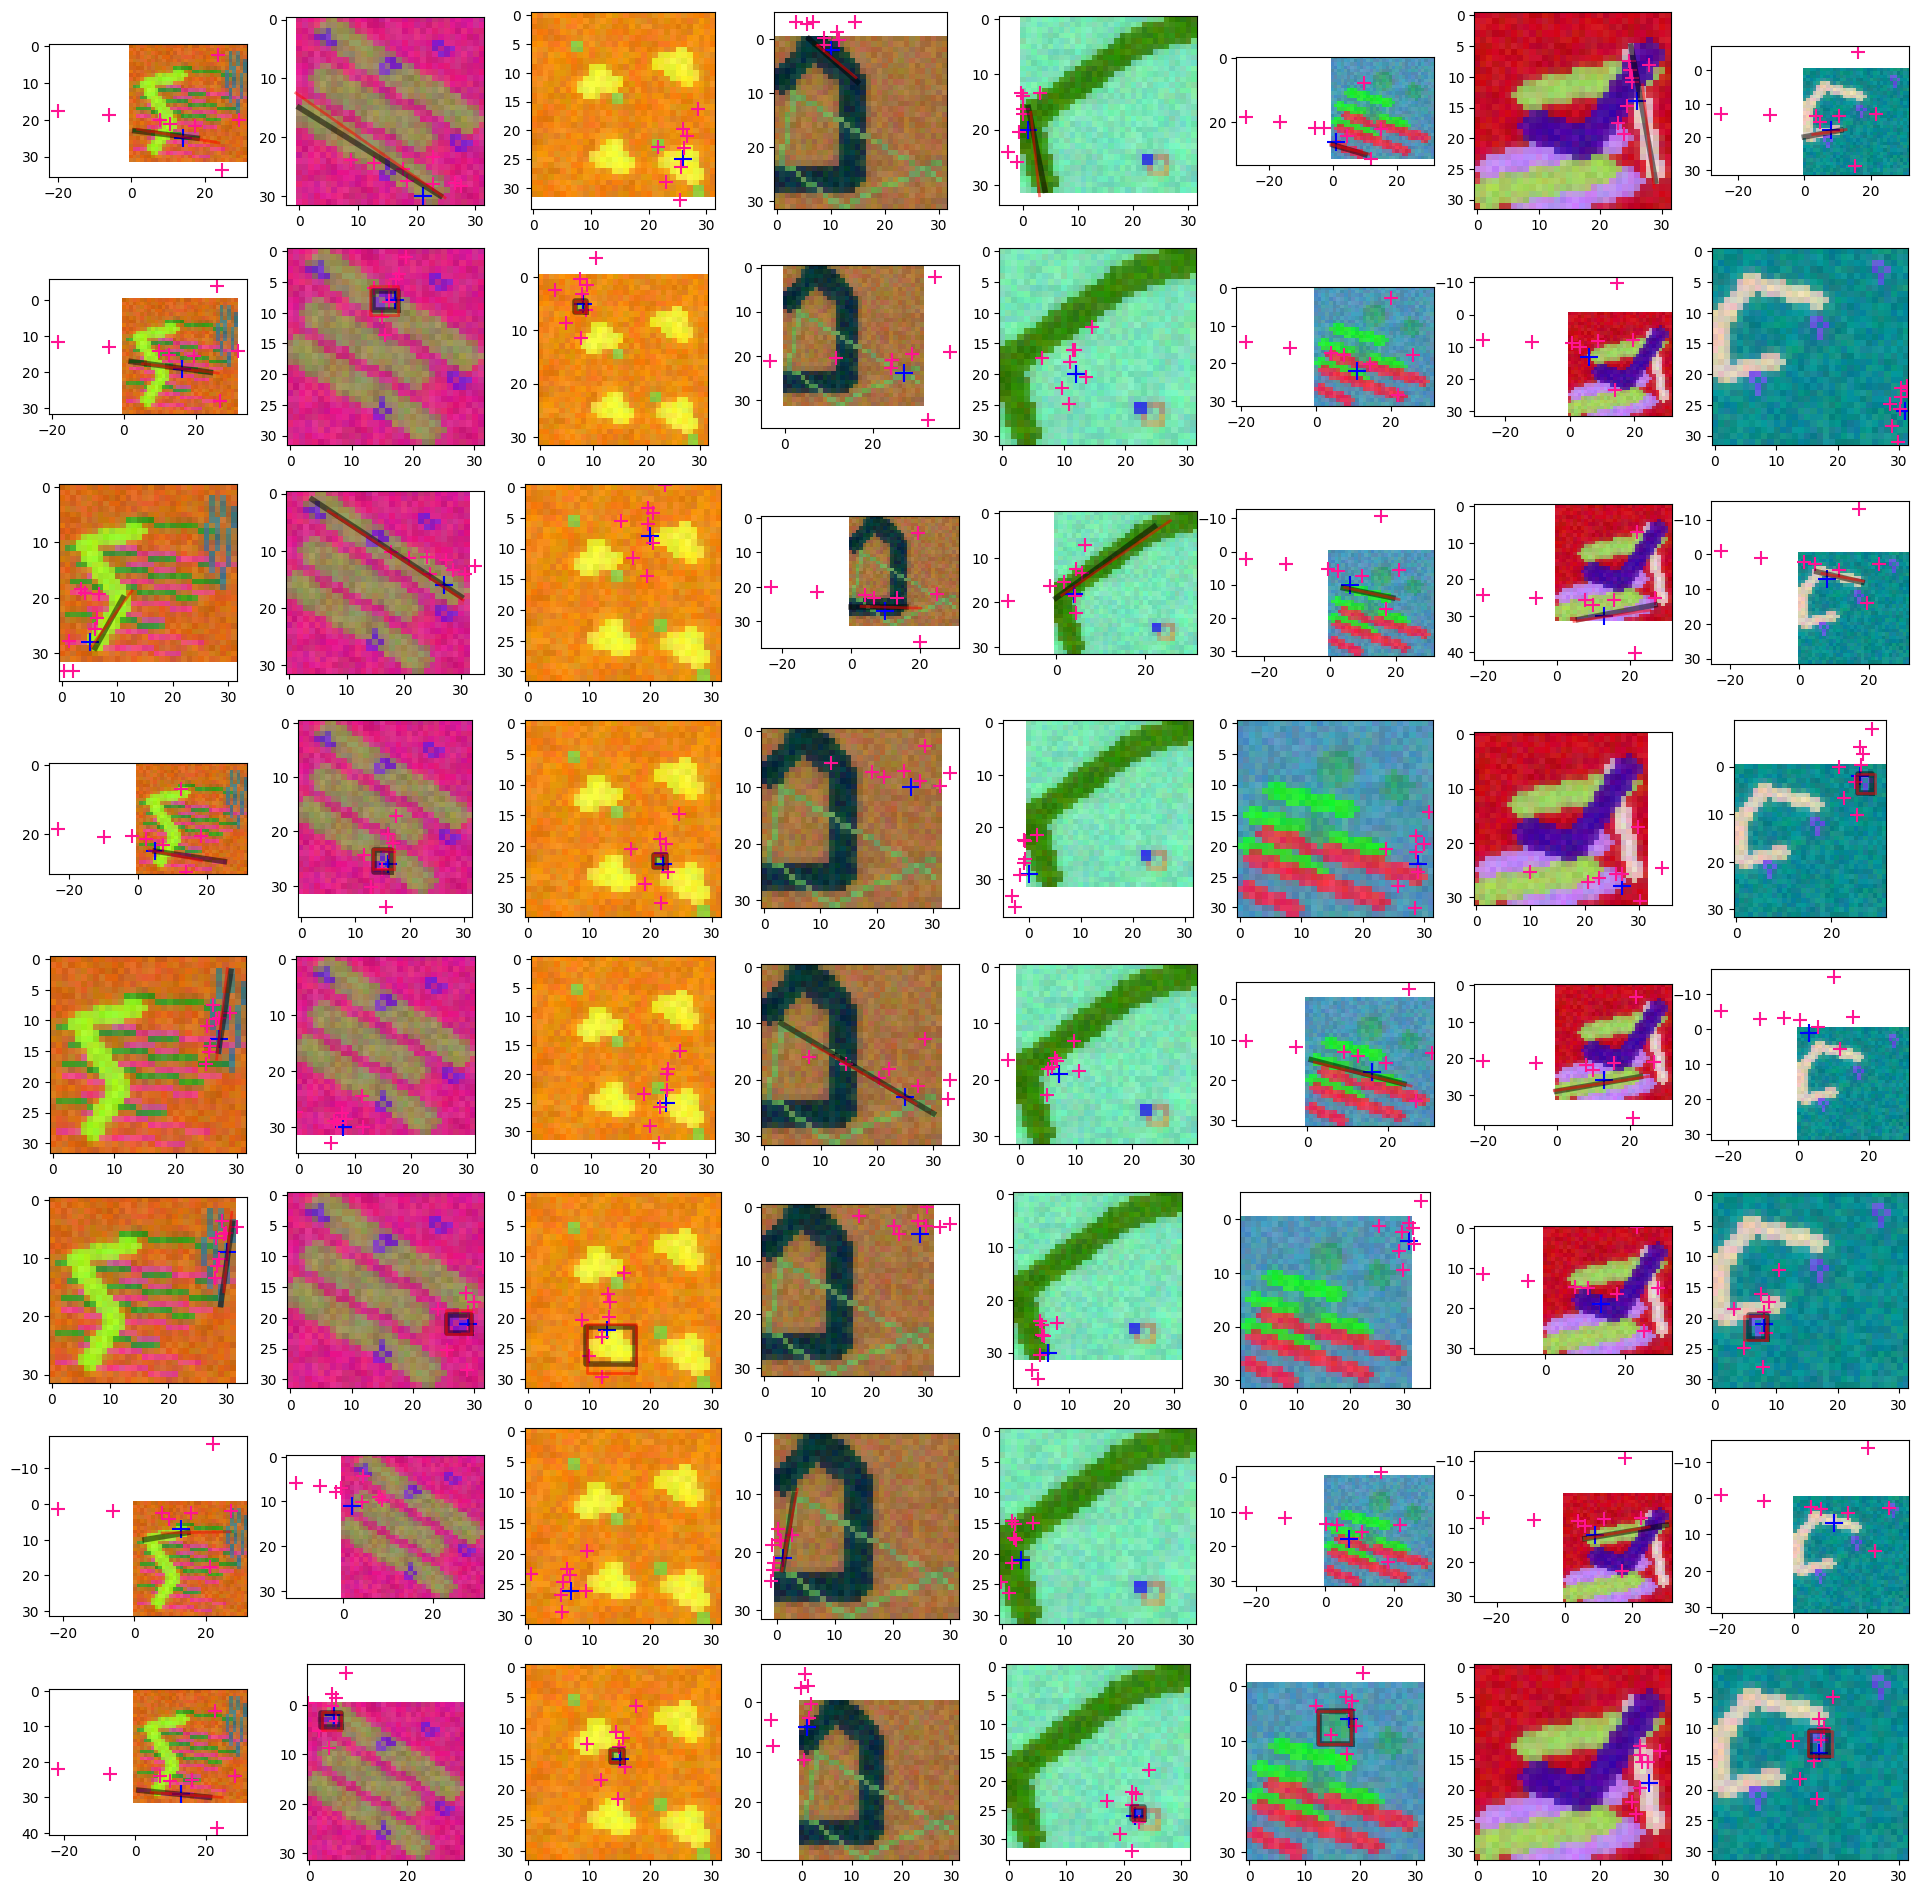

In [37]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)



queries_points, preds  = inter_model(features, training=False)
pred_vecs, pred_class = preds.values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)
print('queries_points', queries_points.shape, queries_points.dtype)
pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=8
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]

    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_queries_points = tf.concat([tf.gather(queries_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(queries_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_weights = tf.concat([tf.gather(class_weights[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(class_weights[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r,i]
        r = r if r%2==0 else r//2+cfg.sample_points//2
        ax.imshow(img[i])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='blue', s=150)
        ax.scatter(*tf.transpose(i_queries_points[r], [1,0])[::-1], marker='+', color='deeppink', s=100)
        if i_weights[r]>0:
            ax.plot(*i_components[r], color='black', linewidth=4, alpha=0.5)
            ax.plot(*p_components[r], color='red', linewidth=2, alpha=0.5)

# experiments

In [13]:
features = tf.ones((8,1,1024,64))
sample_features = tf.ones((8,20,1,64))
sample_points = tf.ones((8,20,2))
pos_enc = tf.ones((8,20,1024,64))

query_points = tf.ones((8,20,6,2))
unsqueezed_features = tf.ones((8,32,32,64))

shape = tf.shape(query_points)
B, sample_points_num, query_points_num = [shape[i] for i in range(3)]
query_boxes = tf.concat([query_points-0.5, query_points+0.5], axis=-1)
print(query_boxes.shape)
box_indices = tf.reshape(tf.repeat(tf.range(B, dtype=tf.int32)[:,tf.newaxis], sample_points_num*query_points_num, axis=-1), (-1,))
print(box_indices.shape)
query_boxes = tf.reshape(query_boxes, (-1,4))
print(query_boxes.shape)

query_samples = tf.image.crop_and_resize(unsqueezed_features, query_boxes, box_indices, crop_size=[1,1])
print(query_samples.shape)
query_samples = tf.reshape(query_samples, (B, sample_points_num, query_points_num, -1))
print(query_samples.shape)

(8, 20, 6, 4)
(960,)
(960, 4)
(960, 1, 1, 64)
(8, 20, 6, 64)


In [ ]:
query_points = vcm.QuerySamplingLayer(queries_num=6, mid_layers=1, mid_units=64, activation='relu', dropout=0.0)([sample_features, sample_points])
print(query_points.shape)

query_samples = vcm.SampleQueryExtractionLayer(crop_size=[1,1])([features, query_points])
print(query_samples.shape)

a = vcm.SampleQueryMessagePassing(num_heads=1, size=32, mid_layers=1, mid_units=64, activation='relu', dropout=0.0, enc_type='frequency')(sample_features, query_samples, sample_points, query_points)
print(a.shape)

(8, 20, 6, 2)
(8, 20, 6, 64)
(8, 20, 1, 64)


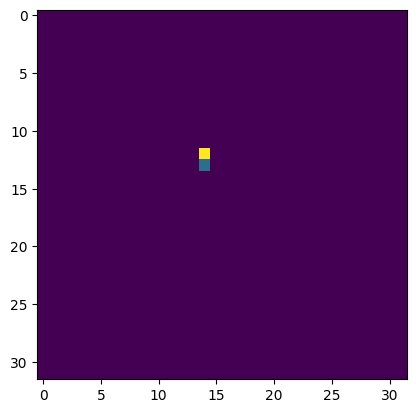

In [ ]:
yx = xy_coords((32,32))[...,::-1]
p = tf.constant([12.4, 14.1], tf.float32)

diffs = tf.reduce_sum(tf.abs(p-yx), axis=-1, keepdims=True)
bilinear_map = tf.nn.relu(1-diffs+1e-4)**2
bilinear_map /= tf.reduce_sum(bilinear_map)+1e-4
plt.imshow(bilinear_map)